In [1]:
import time
import sys, os
import pickle
import numpy as np
import scvelo as scv
import scanpy
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from veloproj import *
from veloproj.model import leastsq_pt
from IPython import display
from matplotlib import pyplot as plt
import anndata

In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr',  '1e-5',
                               '--n-epochs', '20000', 
                               '--g-rep-dim', '100',
                               '--k-dim', '100',
                               '--data-dir', '/data/groups/yhhuang/cqiao/Melania/adata_umap_pca.h5',
                               '--exp-name', 'baseline_Melania_Erythroid_mouse',
                               '--model-name', 'baseline_tmp.cpt',
                               '--device', 'cuda:3',
                               '--gumbsoft_tau', '1',
                               '--nb_g_src', "SU",
                               '--n_raw_gene', '2000',
                              ])

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [4]:
cluster_edges = [("Erythroid1", "Erythroid2"), ('Erythroid2', "Erythroid3")]
k_cluster = "celltype"
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
def main_AE(args, model, lr=args.lr, weight_decay=args.weight_decay, save_name="tmp.cpt", norm_lr=False):
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    lr = args.lr  
    i, losses = 0, [sys.maxsize]  
    min_loss = losses[-1]
    model_saved = False

    model.train()
        
    while i < args.n_epochs:
        i += 1
        loss = train_step_AE([tensor_s, tensor_u], model, optimizer, 
                             xyids=[0, 1],
                             device=device,
                             norm_lr=norm_lr
                             )
        
        losses.append(loss)
        if i % args.log_interval == 0:
            if losses[-1] < min_loss:
                min_loss = losses[-1]
                torch.save(model.state_dict(), os.path.join(args.output, save_name))
                model_saved = True
            else:
                if model_saved:
                    model.load_state_dict(torch.load(os.path.join(args.output, save_name)))
                    model = model.to(device)
                lr *= args.lr_decay
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr

            print("Train Epoch: {:2d}/{:2d} \tLoss: {:.6f}"
                  .format(i, args.n_epochs, losses[-1]))

    plt.plot(losses[1:])
    if losses[-1] < min_loss:
        torch.save(model.state_dict(), os.path.join(args.output, save_name))
    return model

In [6]:
par_path = "/data/users/cqiao/notebooks/projects/PaperRev/VeloRep2/notebooks/Melania_mouse/"
fast_data_path = "data.h5ad"
if fast_data_path in os.listdir(par_path):
    adata = scanpy.read_h5ad(os.path.join(par_path, fast_data_path))
else:
    adata = scanpy.read_h5ad(args.data_dir)
    sel = np.zeros(adata.n_obs, dtype=np.bool)
    sel = sel | (adata.obs.celltype == "Erythroid1").values | (adata.obs.celltype == "Erythroid2").values | (adata.obs.celltype == "Erythroid3").values
    sel = sel | (adata.obs.celltype == "Blood progenitors 1").values | sel | (adata.obs.celltype == "Blood progenitors 2").values
    adata = adata[sel]
    scv.utils.show_proportions(adata)
    scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
    scv.tl.velocity_graph(adata, vkey='stc_velocity')
    scv.tl.velocity_confidence(adata, vkey='stc_velocity')
print(adata)

AnnData object with n_obs × n_vars = 9815 × 2000
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'stc_velocity_self_transition', 'stc_velocity_length', 'stc_velocity_confidence', 'stc_velocity_confidence_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'stc_velocity_gamma', 'stc_velocity_r2', 'stc_velocity_genes'
    uns: 'celltype_colors', 'neighbors', 'stc_velocity_graph', 'stc_velocity_graph_neg', 'stc_velocity_params'
    obsm: 'X_pca', 'X_

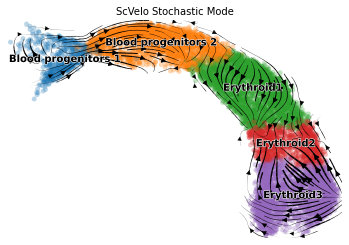

# Cross-Boundary Transition Score (A->B)
{('Erythroid1', 'Erythroid2'): 0.17114995, ('Erythroid2', 'Erythroid3'): 0.09341168}
Total Mean: 0.13228081166744232
# Cross-Boundary Velocity Coherence (A->B)
{('Erythroid1', 'Erythroid2'): 0.6864096, ('Erythroid2', 'Erythroid3'): 0.73946804}
Total Mean: 0.7129387855529785
# Cross-Boundary Direction Correctness (A->B)
{('Erythroid1', 'Erythroid2'): 0.35671440778567015, ('Erythroid2', 'Erythroid3'): -0.5571900059139028}
Total Mean: -0.10023779906411631
# In-cluster Coherence
{'Blood progenitors 1': 0.7551233, 'Blood progenitors 2': 0.7151811, 'Erythroid1': 0.70970446, 'Erythroid2': 0.7345957, 'Erythroid3': 0.8732634}
Total Mean: 0.7575736045837402
# In-cluster Confidence
{'Blood progenitors 1': 0.7300548396083746, 'Blood progenitors 2': 0.6358000902958937, 'Erythroid1': 0.7121040044950506, 'Erythroid2': 0.6815228624434411, 'Erythroid3': 0.9347134761548193}
Total Mean: 0.7388390545995158


In [7]:
scv.pl.velocity_embedding_stream(adata, vkey="stc_velocity", basis='X_umap', color=k_cluster,
                                title='ScVelo Stochastic Mode')
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, k_cluster, "stc_velocity", x_emb="X_umap")

In [8]:
spliced = adata.layers['Ms']
unspliced = adata.layers['Mu']
tensor_s, tensor_u = torch.FloatTensor(spliced).to(device), torch.FloatTensor(unspliced).to(device)
tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

Train Epoch: 100/20000 	Loss: 423.902771
Train Epoch: 200/20000 	Loss: 423.313416
Train Epoch: 300/20000 	Loss: 422.529480
Train Epoch: 400/20000 	Loss: 421.611389
Train Epoch: 500/20000 	Loss: 420.597443
Train Epoch: 600/20000 	Loss: 419.486572
Train Epoch: 700/20000 	Loss: 418.262177
Train Epoch: 800/20000 	Loss: 416.931274
Train Epoch: 900/20000 	Loss: 415.527527
Train Epoch: 1000/20000 	Loss: 414.074280
Train Epoch: 1100/20000 	Loss: 412.567261
Train Epoch: 1200/20000 	Loss: 411.004181
Train Epoch: 1300/20000 	Loss: 409.386078
Train Epoch: 1400/20000 	Loss: 407.720947
Train Epoch: 1500/20000 	Loss: 406.010376
Train Epoch: 1600/20000 	Loss: 404.263733
Train Epoch: 1700/20000 	Loss: 402.492615
Train Epoch: 1800/20000 	Loss: 400.695007
Train Epoch: 1900/20000 	Loss: 398.889465
Train Epoch: 2000/20000 	Loss: 397.069427
Train Epoch: 2100/20000 	Loss: 395.249176
Train Epoch: 2200/20000 	Loss: 393.432220
Train Epoch: 2300/20000 	Loss: 391.612488
Train Epoch: 2400/20000 	Loss: 389.802887
T

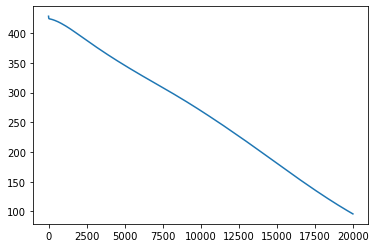

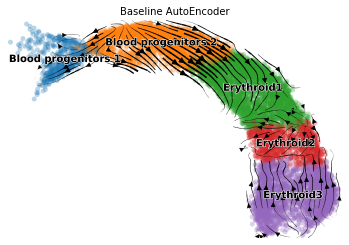

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('Erythroid1', 'Erythroid2'): 0.06937534, ('Erythroid2', 'Erythroid3'): 0.10518896}
Total Mean: 0.08728215098381042
# Cross-Boundary Velocity Coherence (A->B)
{('Erythroid1', 'Erythroid2'): 0.96888876, ('Erythroid2', 'Erythroid3'): 0.9371988}
Total Mean: 0.9530438184738159
# Cross-Boundary Direction Correctness (A->B)
{('Erythroid1', 'Erythroid2'): 0.11929331035487276, ('Erythroid2', 'Erythroid3'): 0.12555576329334295}
Total Mean: 0.12242453682410785
# In-cluster Coherence
{'Blood progenitors 1': 0.9955847, 'Blood progenitors 2': 0.9933005, 'Erythroid1': 0.98858476, 'Erythroid2': 0.97821367, 'Erythroid3': 0.99361795}
Total Mean: 0.9898603558540344
# In-cluster Confidence
{'Blood progenitors 1': 0.9942130989859996, 'Blood progenitors 2': 0.9924690995274521, 'Erythroid1': 0.9868514984693492, 'Eryth

In [9]:
def expBaseAE(adata, exp_metrics):
    n_cells, n_genes = adata.X.shape
    in_dim = n_genes
    z_dim = args.z_dim
    h_dim = args.h_dim
    args.lr = 1e-4
    model = get_baseline_AE(in_dim, z_dim, h_dim, True).to(device)
    model = main_AE(args, model, save_name=f"baseAE_{args.model_name}", norm_lr=True)
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device, norm=True).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
        
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Baseline AutoEncoder",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Baseline AutoEncoder'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expBaseAE(adata, exp_metrics)

computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Train Epoch: 100/20000 	Loss: 422.113373
Train Epoch: 200/20000 	Loss: 413.030426
Train Epoch: 300/20000 	Loss: 385.237305
Train Epoch: 400/20000 	Loss: 324.745941
Train Epoch: 500/20000 	Loss: 226.014160
Train Epoch: 600/20000 	Loss: 123.096191
Train Epoch: 700/20000 	Loss: 64.204132
Train Epoch: 800/20000 	Loss: 45.729149
Train Epoch: 900/20000 	Loss: 41.757690
Train Epoch: 1000/20000 	Loss: 40.246655
Train Epoch: 1100/20000 	Loss: 38.784878
Train Epoch: 1200/20000 	Loss: 37.021053
Train Epoch: 1300/20000 	Loss: 34.839054
Train Epoch: 1400/20000 	Loss: 32.181835
Train Epoch: 1500/20000 	Loss: 29.054674
Train Epoch: 1600/20000 	Loss: 25.626701
Train Epoch: 1700/20000 	Loss: 22.211205
Train Epoch: 1800/20000 	Loss:

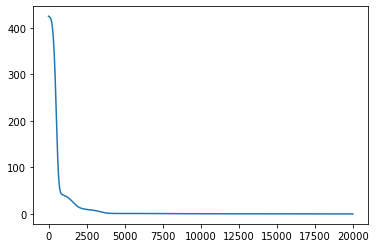

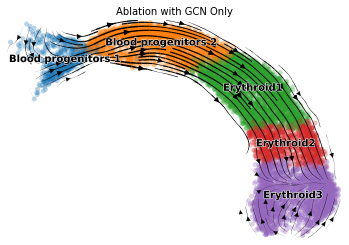

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('Erythroid1', 'Erythroid2'): 0.13418469, ('Erythroid2', 'Erythroid3'): 0.08579276}
Total Mean: 0.10998871922492981
# Cross-Boundary Velocity Coherence (A->B)
{('Erythroid1', 'Erythroid2'): 0.99960613, ('Erythroid2', 'Erythroid3'): 0.9998765}
Total Mean: 0.9997413158416748
# Cross-Boundary Direction Correctness (A->B)
{('Erythroid1', 'Erythroid2'): 0.6569988957265401, ('Erythroid2', 'Erythroid3'): 0.5453751763281722}
Total Mean: 0.6011870360273561
# In-cluster Coherence
{'Blood progenitors 1': 0.99999696, 'Blood progenitors 2': 0.9998084, 'Erythroid1': 0.999686, 'Erythroid2': 0.99978775, 'Erythroid3': 0.99994487}
Total Mean: 0.9998447299003601
# In-cluster Confidence
{'Blood progenitors 1': 0.9999663534172083, 'Blood progenitors 2': 0.999805625352433, 'Erythroid1': 0.9996839265198217, 'Erythroid2

In [10]:
def expAblationCohAgg(adata, exp_metrics):
    n_cells, n_genes = adata.X.shape
    in_dim = n_genes
    z_dim = args.z_dim
    h_dim = args.h_dim
    g_basis = args.nb_g_src
    args.lr = 1e-5
    model = get_ablation_CohAgg(
                                adata,
                                in_dim,
                                z_dim,
                                h_dim,
                                g_basis,
                                device=device)
    model = main_AE(args, model, save_name=f"CohAgg_{args.model_name}")
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
        
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Ablation with GCN Only",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Ablation GCN Only'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expAblationCohAgg(adata, exp_metrics)

Train Epoch: 100/20000 	Loss: 416.665436
Train Epoch: 200/20000 	Loss: 413.851837
Train Epoch: 300/20000 	Loss: 412.481995
Train Epoch: 400/20000 	Loss: 411.675201
Train Epoch: 500/20000 	Loss: 411.165924
Train Epoch: 600/20000 	Loss: 410.785522
Train Epoch: 700/20000 	Loss: 410.503510
Train Epoch: 800/20000 	Loss: 410.267578
Train Epoch: 900/20000 	Loss: 410.028198
Train Epoch: 1000/20000 	Loss: 409.810364
Train Epoch: 1100/20000 	Loss: 409.602539
Train Epoch: 1200/20000 	Loss: 409.387543
Train Epoch: 1300/20000 	Loss: 409.162537
Train Epoch: 1400/20000 	Loss: 408.958282
Train Epoch: 1500/20000 	Loss: 408.756805
Train Epoch: 1600/20000 	Loss: 408.548676
Train Epoch: 1700/20000 	Loss: 408.343689
Train Epoch: 1800/20000 	Loss: 408.164886
Train Epoch: 1900/20000 	Loss: 407.954315
Train Epoch: 2000/20000 	Loss: 407.759277
Train Epoch: 2100/20000 	Loss: 407.572174
Train Epoch: 2200/20000 	Loss: 407.384521
Train Epoch: 2300/20000 	Loss: 407.197937
Train Epoch: 2400/20000 	Loss: 407.014954
T

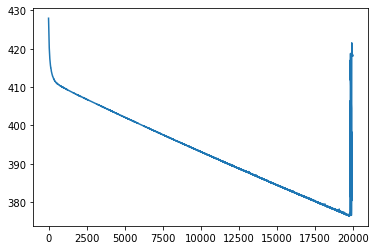

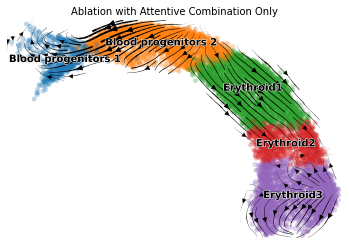

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('Erythroid1', 'Erythroid2'): 0.056401424, ('Erythroid2', 'Erythroid3'): 0.034039762}
Total Mean: 0.04522059112787247
# Cross-Boundary Velocity Coherence (A->B)
{('Erythroid1', 'Erythroid2'): 0.9863207, ('Erythroid2', 'Erythroid3'): 0.9866536}
Total Mean: 0.9864871501922607
# Cross-Boundary Direction Correctness (A->B)
{('Erythroid1', 'Erythroid2'): 0.46846863570035346, ('Erythroid2', 'Erythroid3'): 0.04044742655503643}
Total Mean: 0.25445803112769494
# In-cluster Coherence
{'Blood progenitors 1': 0.9929368, 'Blood progenitors 2': 0.9891171, 'Erythroid1': 0.98915964, 'Erythroid2': 0.98882735, 'Erythroid3': 0.98577386}
Total Mean: 0.9891630411148071
# In-cluster Confidence
{'Blood progenitors 1': 0.9898287700803092, 'Blood progenitors 2': 0.9882558410487524, 'Erythroid1': 0.9882739466300553, 'Eryt

In [11]:
def expAblationAttComb(adata, exp_metrics):
    from sklearn.decomposition import PCA
    n_cells, n_genes = adata.X.shape
    z_dim = args.z_dim
    g_rep_dim = args.g_rep_dim
    h_dim = args.h_dim
    k_dim = args.k_dim
    gb_tau = args.gumbsoft_tau
    args.lr = 1e-4
    
    G_embeddings = PCA(n_components=g_rep_dim).fit_transform(adata.X.T.toarray())
    
    model = get_ablation_attcomb(
        z_dim,
        n_genes,
        n_cells,
        h_dim,
        k_dim,
        G_embeddings,
        g_rep_dim,
        gb_tau,
        device,
        True
    )
    
            
    model = main_AE(args, model, save_name=f"AttComb_{args.model_name}", norm_lr=True)
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device, norm=True).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Ablation with Attentive Combination Only",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Ablation AttComb Only'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expAblationAttComb(adata, exp_metrics)

computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:02) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:02) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


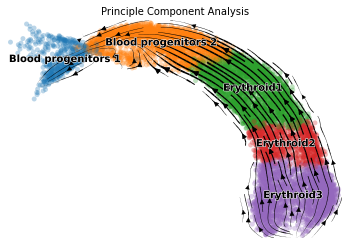

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('Erythroid1', 'Erythroid2'): 0.16112798, ('Erythroid2', 'Erythroid3'): 0.15862203}
Total Mean: 0.15987500548362732
# Cross-Boundary Velocity Coherence (A->B)
{('Erythroid1', 'Erythroid2'): 0.9869392, ('Erythroid2', 'Erythroid3'): 0.9935835}
Total Mean: 0.9902613162994385
# Cross-Boundary Direction Correctness (A->B)
{('Erythroid1', 'Erythroid2'): -0.6599346962304471, ('Erythroid2', 'Erythroid3'): -0.5679988987447122}
Total Mean: -0.6139667974875797
# In-cluster Coherence
{'Blood progenitors 1': 0.9749022, 'Blood progenitors 2': 0.97088164, 'Erythroid1': 0.98633856, 'Erythroid2': 0.9967772, 'Erythroid3': 0.9958287}
Total Mean: 0.9849456548690796
# In-cluster Confidence
{'Blood progenitors 1': 0.9704052979069766, 'Blood progenitors 2': 0.9688055371850487, 'Erythroid1': 0.9828119506075668, 'Erythro

In [12]:
def expPCA(adata, exp_metrics):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=args.z_dim)
    x, s, u, v = sklearn_decompose(pca, 
                                   tensor_x.detach().cpu().numpy(), 
                                   tensor_s.detach().cpu().numpy(), 
                                   tensor_u.detach().cpu().numpy(), 
                                   tensor_v.detach().cpu().numpy(),
                                   norm_lr=True
                                  )
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Principle Component Analysis",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Baseline PCA'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expPCA(adata, exp_metrics)

computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:02) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:02) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


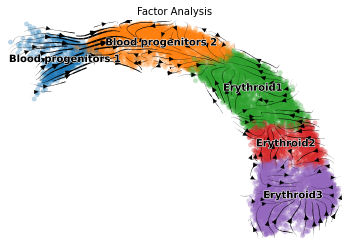

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('Erythroid1', 'Erythroid2'): 0.10624498, ('Erythroid2', 'Erythroid3'): 0.10757685}
Total Mean: 0.10691091418266296
# Cross-Boundary Velocity Coherence (A->B)
{('Erythroid1', 'Erythroid2'): 0.25695428347377863, ('Erythroid2', 'Erythroid3'): 0.26768856349485765}
Total Mean: 0.26232142348431814
# Cross-Boundary Direction Correctness (A->B)
{('Erythroid1', 'Erythroid2'): 0.24152010606386648, ('Erythroid2', 'Erythroid3'): 0.17569147514943323}
Total Mean: 0.20860579060664985
# In-cluster Coherence
{'Blood progenitors 1': 0.4596915533711601, 'Blood progenitors 2': 0.3412104113052528, 'Erythroid1': 0.31335829104759416, 'Erythroid2': 0.36699665803544007, 'Erythroid3': 0.32197788440033454}
Total Mean: 0.3606469596319563
# In-cluster Confidence
{'Blood progenitors 1': 0.3647497390777023, 'Blood progenitors

In [13]:
def expFA(adata, exp_metrics):
    from sklearn.decomposition import FactorAnalysis
    method = FactorAnalysis(n_components=args.z_dim)
    x, s, u, v = sklearn_decompose(method,
                                   tensor_x.detach().cpu().numpy(), 
                                   tensor_s.detach().cpu().numpy(), 
                                   tensor_u.detach().cpu().numpy(), 
                                   tensor_v.detach().cpu().numpy(),
                                   norm_lr=True
                                  )
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Factor Analysis",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Baseline FA'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expFA(adata, exp_metrics)

In [14]:
with open("{}.pkl".format(EXP_NAME), 'wb') as out_file:
    pickle.dump(exp_metrics, out_file)